In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
import os

from parser.parse_csv import get_dt

In [2]:
figures_dir = "figures"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

In [3]:
# def latexify(fig_width=None, fig_height=None, columns=1):
#     """Set up matplotlib's RC params for LaTeX plotting.
#     Call this before plotting a figure.

#     Parameters
#     ----------
#     fig_width : float, optional, inches
#     fig_height : float,  optional, inches
#     columns : {1, 2}
#     """

#     # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

#     # Width and max height in inches for IEEE journals taken from
#     # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

#     assert(columns in [1,2])

#     if fig_width is None:
#         fig_width = 3.39 if columns==1 else 6.9 # width in inches

#     if fig_height is None:
#         golden_mean = (math.sqrt(5)-1.0)/2.0    # Aesthetic ratio
#         fig_height = fig_width*golden_mean # height in inches
    
#     MAX_HEIGHT_INCHES = 8.0
#     if fig_height > MAX_HEIGHT_INCHES:
#         print("WARNING: fig_height too large:" + fig_height + 
#               "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
#         fig_height = MAX_HEIGHT_INCHES

#     params = {'backend': 'ps',
#               'text.latex.preamble': ["\\usepackage{libertine}"],
#               'axes.labelsize': 8, # fontsize for x and y labels (was 10)
#               'axes.titlesize': 8,
# #               'text.fontsize': 8, # was 10
#               'legend.fontsize': 8, # was 10
#               'xtick.labelsize': 8,
#               'ytick.labelsize': 8,
#               'text.usetex': True,
#               'figure.figsize': [fig_width, fig_height],
#               'font.family': 'serif',
#               'mathtext.default': 'regular'
#     }

#     matplotlib.rcParams.update(params)

# %matplotlib inline

# latexify()

In [4]:
mnist_valid_labels = pd.read_csv("parser/mnist_valid_labels.csv").set_index("SampleNumber")
mnist_test_labels = pd.read_csv("parser/mnist_test_labels.csv").set_index("SampleNumber")
fashion_mnist_valid_labels = pd.read_csv("parser/fashion_mnist_valid_labels.csv").set_index("SampleNumber")
fashion_mnist_test_labels = pd.read_csv("parser/fashion_mnist_test_labels.csv").set_index("SampleNumber")
cifar10_valid_labels = pd.read_csv("parser/cifar10_valid_labels.csv").set_index("SampleNumber")
cifar10_test_labels = pd.read_csv("parser/cifar10_test_labels.csv").set_index("SampleNumber")

In [5]:
def get_accuracies_valid(filename, dataset="mnist"):
    if dataset == "mnist":
        labels = mnist_valid_labels
    elif dataset == "fashion_mnist":
        labels = fashion_mnist_valid_labels
    else:
        labels = cifar10_valid_labels
    dt = get_dt(filename, labels)

    adv_results = dt.groupby("ProcessedSolveStatus")["SolveStatus"].count().to_dict()
#     print(adv_results)
    cumulative_adv_results = []
    accumulator = adv_results["ProvablyRobustByClass"]
    del adv_results["ProvablyRobustByClass"]
    adv_results_numbers = {}
    for k, v in adv_results.items():
        if k.startswith("InfeasibleDistance"):
            dist = float(k[18:])
        elif k.startswith("InfeasibleUndecidedDistance"):
            dist = float(k[27:])
        else:
            continue
        adv_results_numbers[dist] = adv_results_numbers.get(dist, 0) + v
    for i in range(-24, 41):
        if i / 10 in adv_results_numbers:
            accumulator += adv_results_numbers[i / 10]
        cumulative_adv_results.append(accumulator)
    # Exclude 4.0 distance
    cumulative_adv_results = cumulative_adv_results[:-1]

    if "StatusUnknown" in adv_results:
        accumulator += adv_results["StatusUnknown"]
    
    if accumulator != 5000:
        print("Only", accumulator, "samples verified so far")

    nat_results = [
        np.logical_and(
            dt["NaturalInputMinDistance"].values >= x / 10,
            (dt.PredictedIndex == dt.TrueIndex).values
        ).sum()
        for x in range(-24, 40) # Exclude 4.0 distance
    ]

    return (np.asarray(nat_results) / accumulator,
        np.asarray(cumulative_adv_results) / accumulator)

def get_accuracies_test(filename, threshold=None, dataset="mnist"):
    if dataset == "mnist":
        labels = mnist_test_labels
    elif dataset == "fashion_mnist":
        labels = fashion_mnist_test_labels
    else:
        labels = cifar10_test_labels
    dt = get_dt(filename, labels)

    if threshold is not None:
        nat_results = np.logical_and(dt["NaturalInputMinDistance"].values >= threshold,
                                     (dt.PredictedIndex == dt.TrueIndex).values).sum()
    else:
        nat_results = (dt.PredictedIndex == dt.TrueIndex).values.sum()

    adv_results = dt.groupby("ProcessedSolveStatus")["PredictedIndex"].count().to_dict()
    
    print(adv_results)
    
    if "InfeasibleDistance" in adv_results:
        adv_results["ProvablyRobustByClass"] += adv_results["InfeasibleDistance"]

    return (nat_results / dt["PredictedIndex"].count(),
            adv_results["ProvablyRobustByClass"] / dt["PredictedIndex"].count())

def get_accuracies_test_human_experts(filename, threshold, dataset="mnist"):
    if dataset == "mnist":
        labels = mnist_test_labels
    elif dataset == "fashion_mnist":
        labels = fashion_mnist_test_labels
    else:
        labels = cifar10_test_labels
    dt = get_dt(filename, labels)

    nat_results = np.logical_or(
        dt["NaturalInputMinDistance"].values < threshold,
        (dt.PredictedIndex == dt.TrueIndex).values
    ).sum()

    adv_results = dt.groupby("ProcessedSolveStatus")["PredictedIndex"].count().to_dict()
    
    print(adv_results)

    if "InfeasibleDistance" in adv_results:
        adv_results["ProvablyRobustByClass"] += adv_results["InfeasibleDistance"]

    return (nat_results / dt["PredictedIndex"].count(),
            adv_results["ProvablyRobustByClass"] / dt["PredictedIndex"].count(),
            (dt["NaturalInputMinDistance"].values < threshold).sum() / dt["PredictedIndex"].count())

## Test results

In [6]:
for dataset in ["IBP_MNIST_SmallCNN_train_0.200_eval_0.100_elide/Apr29_22-00-04/weights_100_0.971__linf-norm-bounded-0.1__Inf__0.0",
                "IBP_MNIST_MediumCNN_train_0.200_eval_0.100_elide/Apr29_21-58-36/weights_100_0.973__linf-norm-bounded-0.1__Inf__0.0",
                "IBP_MNIST_SmallCNN_train_0.300_eval_0.200_elide/May01_09-41-57/weights_100_0.946__linf-norm-bounded-0.2__Inf__0.0",
                "IBP_MNIST_MediumCNN_train_0.300_eval_0.200_elide/May01_10-45-41/weights_100_0.953__linf-norm-bounded-0.2__Inf__0.0",
                "IBP_MNIST_SmallCNN_train_0.400_eval_0.300_elide/Apr29_22-01-57/weights_100_0.906__linf-norm-bounded-0.3__Inf__0.0",
                "IBP_MNIST_MediumCNN_train_0.400_eval_0.300_elide/Apr29_21-55-33/weights_100_0.915__linf-norm-bounded-0.3__Inf__0.0",
                "RS_MNIST_SmallCNN_eps_0.100/May04_00-42-45/weights_070_0.96__linf-norm-bounded-0.1__Inf__0.0",
                "RS_MNIST_SmallCNN_eps_0.200/May04_00-43-25/weights_070_0.95__linf-norm-bounded-0.2__Inf__0.0",
                "RS_MNIST_SmallCNN_eps_0.300/May06_09-53-34/weights_070_0.91__linf-norm-bounded-0.3__Inf__0.0"]:
    filename = "verification_results/test/" + dataset + "/summary.csv"
    print(dataset)
    print(get_accuracies_test(filename))
    print()

IBP_MNIST_SmallCNN_train_0.200_eval_0.100_elide/Apr29_22-00-04/weights_100_0.971__linf-norm-bounded-0.1__Inf__0.0
{'ProvablyRobustByClass': 9688, 'Vulnerable': 312}
(0.9843, 0.9688)

IBP_MNIST_MediumCNN_train_0.200_eval_0.100_elide/Apr29_21-58-36/weights_100_0.973__linf-norm-bounded-0.1__Inf__0.0
{'ProvablyRobustByClass': 9732, 'Vulnerable': 267, 'StatusUnknown': 1}
(0.9868, 0.9732)

IBP_MNIST_SmallCNN_train_0.300_eval_0.200_elide/May01_09-41-57/weights_100_0.946__linf-norm-bounded-0.2__Inf__0.0
{'ProvablyRobustByClass': 9389, 'Vulnerable': 611}
(0.9762, 0.9389)

IBP_MNIST_MediumCNN_train_0.300_eval_0.200_elide/May01_10-45-41/weights_100_0.953__linf-norm-bounded-0.2__Inf__0.0
{'ProvablyRobustByClass': 9524, 'Vulnerable': 471, 'StatusUnknown': 5}
(0.9814, 0.9524)

IBP_MNIST_SmallCNN_train_0.400_eval_0.300_elide/Apr29_22-01-57/weights_100_0.906__linf-norm-bounded-0.3__Inf__0.0
{'ProvablyRobustByClass': 8941, 'Vulnerable': 1059}
(0.9652, 0.8941)

IBP_MNIST_MediumCNN_train_0.400_eval_0.300

## MNIST 0.1

Maximise nat and adv accuracy at delta =  0.4
Nat accuracy 0.9798
Adv accuracy 0.98 

Maximise nat and adv accuracy at delta =  0.6
Nat accuracy 0.9836
Adv accuracy 0.9832 

Maximise nat and adv accuracy at delta =  0.1
Nat accuracy 0.9874
Adv accuracy 0.9874 



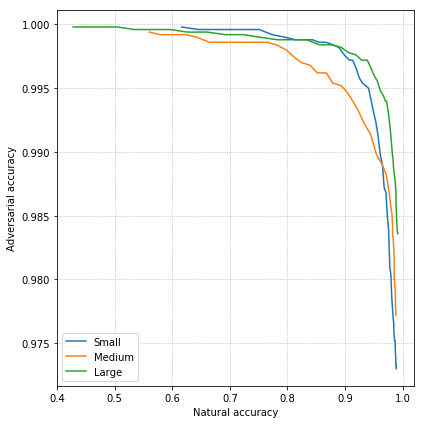

In [7]:
plt.figure()

# Set height = width
fig = plt.gcf()
width, height = fig.get_size_inches()
fig.set_size_inches(width, width)

for dataset, label in zip(["IBP_MNIST_SmallCNN_train_0.200_eval_0.100_elide/Apr29_22-00-04/weights_100_0.971__linf-norm-bounded-0.1__Inf__0.0",
                           "IBP_MNIST_MediumCNN_train_0.200_eval_0.100_elide/Apr29_21-58-36/weights_100_0.973__linf-norm-bounded-0.1__Inf__0.0",
                           "IBP_MNIST_LargeCNN_train_0.200_eval_0.100_elide/Apr29_21-41-43/weights_100_0.980__linf-norm-bounded-0.1__Inf__0.0"],
                          ["Small", "Medium", "Large"]):

    filename = "verification_results/validation/" + dataset + "/summary.csv"
    nat_accuracies, adv_accuracies = get_accuracies_valid(filename)
    plt.plot(nat_accuracies, adv_accuracies, label=label)
    plt.xlabel("Natural accuracy")
    plt.ylabel("Adversarial accuracy")

    plt.grid(True, "both", linestyle="dotted")

    max_min = 0
    nat_acc = -1
    adv_acc = -1
    epsilon = 0
    for (a, b, c) in zip(nat_accuracies, adv_accuracies, range(-24, 41)):
        if min(a, b) > max_min:
            max_min = min(a, b)
            nat_acc = a
            adv_acc = b
            epsilon = c / 10

    print("Maximise nat and adv accuracy at delta = ", epsilon)
    print("Nat accuracy", nat_acc)
    print("Adv accuracy", adv_acc, "\n")

# plt.axis([0.5,1,0.97,1])
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "verification_validation_mnist_01.pdf"), bbox_inches="tight", pad_inches=0)

In [8]:
large_01_test = "verification_results/test_min_dist_0.1/IBP_MNIST_LargeCNN_train_0.200_eval_0.100_elide/Apr29_21-41-43/weights_100_0.980__linf-norm-bounded-0.1__Inf__0.0/summary.csv"
print(get_accuracies_test(large_01_test, 0.1))

{'ProvablyRobustByClass': 9776, 'InfeasibleDistance': 59, 'Vulnerable': 161, 'StatusUnknown': 4}
(0.9834, 0.9835)


## MNIST 0.2

Maximise nat and adv accuracy at delta =  0.9
Nat accuracy 0.9672
Adv accuracy 0.968 

Maximise nat and adv accuracy at delta =  1.0
Nat accuracy 0.9708
Adv accuracy 0.971 

Maximise nat and adv accuracy at delta =  0.7
Nat accuracy 0.9746
Adv accuracy 0.9738 



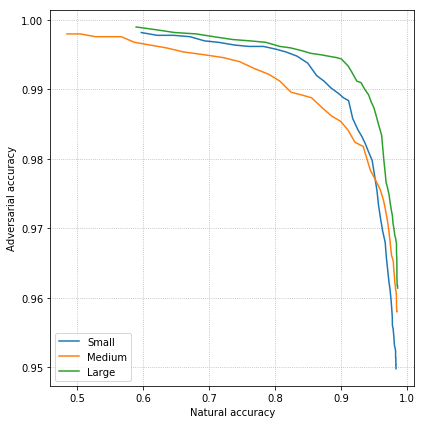

In [9]:
plt.figure()

# Set height = width
fig = plt.gcf()
width, height = fig.get_size_inches()
fig.set_size_inches(width, width)

for dataset, label in zip(["IBP_MNIST_SmallCNN_train_0.300_eval_0.200_elide/May01_09-41-57/weights_100_0.946__linf-norm-bounded-0.2__Inf__0.0",
                           "IBP_MNIST_MediumCNN_train_0.300_eval_0.200_elide/May01_10-45-41/weights_100_0.953__linf-norm-bounded-0.2__Inf__0.0",
                           "IBP_MNIST_LargeCNN_train_0.300_eval_0.200_elide/May01_10-46-22/weights_100_0.956__linf-norm-bounded-0.2__Inf__0.0"],
                          ["Small", "Medium", "Large"]):

    filename = "verification_results/validation/" + dataset + "/summary.csv"
    nat_accuracies, adv_accuracies = get_accuracies_valid(filename)
    plt.plot(nat_accuracies, adv_accuracies, label=label)
    plt.xlabel("Natural accuracy")
    plt.ylabel("Adversarial accuracy")

    plt.grid(True, "both", linestyle="dotted")

    max_min = 0
    nat_acc = -1
    adv_acc = -1
    epsilon = 0
    for (a, b, c) in zip(nat_accuracies, adv_accuracies, range(-24, 41)):
        if min(a, b) > max_min:
            max_min = min(a, b)
            nat_acc = a
            adv_acc = b
            epsilon = c / 10

    print("Maximise nat and adv accuracy at delta = ", epsilon)
    print("Nat accuracy", nat_acc)
    print("Adv accuracy", adv_acc, "\n")

# plt.axis([0.5,1,0.95,1])
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "verification_validation_mnist_02.pdf"), bbox_inches="tight", pad_inches=0)

In [10]:
large_02_test = "verification_results/test_min_dist_0.7/IBP_MNIST_LargeCNN_train_0.300_eval_0.200_elide/May01_10-46-22/weights_100_0.956__linf-norm-bounded-0.2__Inf__0.0/summary.csv"
print(get_accuracies_test(large_02_test, 0.7))

{'ProvablyRobustByClass': 9535, 'InfeasibleDistance': 144, 'Vulnerable': 255, 'StatusUnknown': 66}
(0.9694, 0.9679)


## MNIST 0.3

Maximise nat and adv accuracy at delta =  1.0
Nat accuracy 0.9448
Adv accuracy 0.9444 

Maximise nat and adv accuracy at delta =  1.1
Nat accuracy 0.9492
Adv accuracy 0.9434 

Maximise nat and adv accuracy at delta =  1.3
Nat accuracy 0.9562
Adv accuracy 0.957 



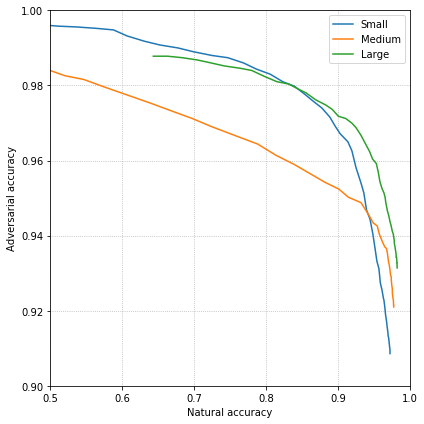

In [11]:
plt.figure()

# Set height = width
fig = plt.gcf()
width, height = fig.get_size_inches()
fig.set_size_inches(width, width)

for dataset, label in zip(["IBP_MNIST_SmallCNN_train_0.400_eval_0.300_elide/Apr29_22-01-57/weights_100_0.906__linf-norm-bounded-0.3__Inf__0.0",
                           "IBP_MNIST_MediumCNN_train_0.400_eval_0.300_elide/Apr29_21-55-33/weights_100_0.915__linf-norm-bounded-0.3__Inf__0.0",
                           "IBP_MNIST_LargeCNN_train_0.400_eval_0.300_elide/Apr29_21-47-39/weights_100_0.926__linf-norm-bounded-0.3__Inf__0.0"],
                          ["Small", "Medium", "Large"]):

    filename = "verification_results/validation/" + dataset + "/summary.csv"
    nat_accuracies, adv_accuracies = get_accuracies_valid(filename)
    
    plt.plot(nat_accuracies, adv_accuracies, label=label)
    plt.xlabel("Natural accuracy")
    plt.ylabel("Adversarial accuracy")

    plt.grid(True, "both", linestyle="dotted")

    max_min = 0
    nat_acc = -1
    adv_acc = -1
    epsilon = 0
    for (a, b, c) in zip(nat_accuracies, adv_accuracies, range(-24, 41)):
        if min(a, b) > max_min:
            max_min = min(a, b)
            nat_acc = a
            adv_acc = b
            epsilon = c / 10

    print("Maximise nat and adv accuracy at delta = ", epsilon)
    print("Nat accuracy", nat_acc)
    print("Adv accuracy", adv_acc, "\n")

plt.axis([0.5,1,0.90,1])
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "verification_validation_mnist_03.pdf"), bbox_inches="tight", pad_inches=0)

In [12]:
large_02_test = "verification_results/test_min_dist_1.3/IBP_MNIST_LargeCNN_train_0.400_eval_0.300_elide/Apr29_21-47-39/weights_100_0.926__linf-norm-bounded-0.3__Inf__0.0/summary.csv"
print(get_accuracies_test(large_02_test, 1.3))

{'ProvablyRobustByClass': 9159, 'InfeasibleDistance': 310, 'Vulnerable': 362, 'StatusUnknown': 169}
(0.9464, 0.9469)


## Use human experts

In [13]:
for dataset in ["IBP_MNIST_LargeCNN_train_0.200_eval_0.100_elide/Apr29_21-41-43/weights_100_0.980__linf-norm-bounded-0.1__Inf__0.0",
                "IBP_MNIST_LargeCNN_train_0.300_eval_0.200_elide/May01_10-46-22/weights_100_0.956__linf-norm-bounded-0.2__Inf__0.0",
                "IBP_MNIST_LargeCNN_train_0.400_eval_0.300_elide/Apr29_21-47-39/weights_100_0.926__linf-norm-bounded-0.3__Inf__0.0"]:
    filename = "verification_results/validation/" + dataset + "/summary.csv"
    dt = get_dt(filename, mnist_valid_labels)
    nat_results = [(dt["NaturalInputMinDistance"].values >= x / 10).sum()
                   for x in range(-24, 40)] # Exclude 4.0 distance
    nat_accuracies, adv_accuracies = get_accuracies_valid(filename)

    nat_results = [x for x in nat_results if x >= 4800]
    index = len(nat_results)
    print(index, (index - 24) / 10, nat_results[-1], adv_accuracies[index])

39 1.5 4815 0.9956
38 1.4 4820 0.9848
37 1.3 4801 0.957


## Withold 5%

In [14]:
for dataset, index in zip(["IBP_MNIST_LargeCNN_train_0.200_eval_0.100_elide/Apr29_21-41-43/weights_100_0.980__linf-norm-bounded-0.1__Inf__0.0",
                           "IBP_MNIST_LargeCNN_train_0.300_eval_0.200_elide/May01_10-46-22/weights_100_0.956__linf-norm-bounded-0.2__Inf__0.0",
                           "IBP_MNIST_LargeCNN_train_0.400_eval_0.300_elide/Apr29_21-47-39/weights_100_0.926__linf-norm-bounded-0.3__Inf__0.0"],
                          [39, 38, 37]):
    threshold = (index - 24) / 10
    filename = "verification_results/test_min_dist_" + str(threshold) + "/" + dataset + "/summary.csv"
    print(get_accuracies_test_human_experts(filename, threshold))

{'ProvablyRobustByClass': 9776, 'InfeasibleDistance': 167, 'Vulnerable': 53, 'StatusUnknown': 4}
(0.9981, 0.9943, 0.0458)
{'ProvablyRobustByClass': 9535, 'InfeasibleDistance': 246, 'Vulnerable': 167, 'StatusUnknown': 52}
(0.998, 0.9781, 0.0473)
{'ProvablyRobustByClass': 9159, 'InfeasibleDistance': 310, 'Vulnerable': 362, 'StatusUnknown': 169}
(0.9962, 0.9469, 0.0498)


## Withold 10%

In [15]:
for dataset, index in zip(["IBP_MNIST_LargeCNN_train_0.200_eval_0.100_elide/Apr29_21-41-43/weights_100_0.980__linf-norm-bounded-0.1__Inf__0.0",
                           "IBP_MNIST_LargeCNN_train_0.300_eval_0.200_elide/May01_10-46-22/weights_100_0.956__linf-norm-bounded-0.2__Inf__0.0",
                           "IBP_MNIST_LargeCNN_train_0.400_eval_0.300_elide/Apr29_21-47-39/weights_100_0.926__linf-norm-bounded-0.3__Inf__0.0"],
                          [45, 46, 46]):
    threshold = (index - 24) / 10
    filename = "verification_results/test_min_dist_" + str(threshold) + "/" + dataset + "/summary.csv"
    print(get_accuracies_test_human_experts(filename, threshold))

{'ProvablyRobustByClass': 9776, 'InfeasibleDistance': 197, 'Vulnerable': 23, 'StatusUnknown': 4}
(0.9993, 0.9973, 0.1033)
{'ProvablyRobustByClass': 9535, 'InfeasibleDistance': 345, 'Vulnerable': 76, 'StatusUnknown': 44}
(0.9991, 0.988, 0.0942)
{'ProvablyRobustByClass': 9161, 'InfeasibleDistance': 526, 'Vulnerable': 215, 'StatusUnknown': 98}
(0.9984, 0.9687, 0.1074)


## Withold 20%

In [16]:
for dataset, index in zip(["IBP_MNIST_LargeCNN_train_0.200_eval_0.100_elide/Apr29_21-41-43/weights_100_0.980__linf-norm-bounded-0.1__Inf__0.0",
                           "IBP_MNIST_LargeCNN_train_0.300_eval_0.200_elide/May01_10-46-22/weights_100_0.956__linf-norm-bounded-0.2__Inf__0.0",
                           "IBP_MNIST_LargeCNN_train_0.400_eval_0.300_elide/Apr29_21-47-39/weights_100_0.926__linf-norm-bounded-0.3__Inf__0.0"],
                          [49, 54, 53]):
    threshold = (index - 24) / 10
    filename = "verification_results/test_min_dist_" + str(threshold) + "/" + dataset + "/summary.csv"
    print(get_accuracies_test_human_experts(filename, threshold))

{'ProvablyRobustByClass': 9776, 'InfeasibleDistance': 208, 'Vulnerable': 14, 'StatusUnknown': 2}
(0.9998, 0.9984, 0.1887)
{'ProvablyRobustByClass': 9535, 'InfeasibleDistance': 412, 'Vulnerable': 26, 'StatusUnknown': 27}
(0.9998, 0.9947, 0.211)
{'ProvablyRobustByClass': 9161, 'InfeasibleDistance': 654, 'Vulnerable': 125, 'StatusUnknown': 60}
(0.9996, 0.9815, 0.1925)


## CIFAR-10 2/255

Maximise nat and adv accuracy at delta =  0.3
Nat accuracy 0.5256
Adv accuracy 0.5484 



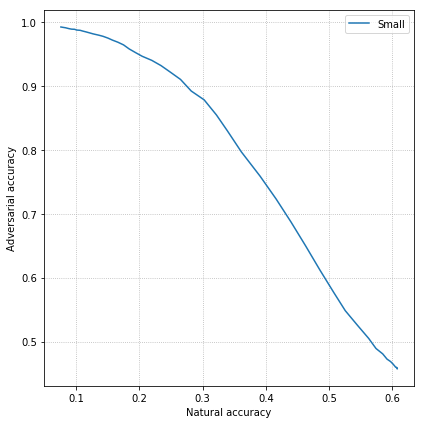

In [17]:
plt.figure()

# Set height = width
fig = plt.gcf()
width, height = fig.get_size_inches()
fig.set_size_inches(width, width)

for dataset, label in zip(["IBP_CIFAR10_SmallCNN_train_0.009_eval_0.008_elide/May06_13-14-55/weights_350_0.434__linf-norm-bounded-0.007843137__Inf__0.0",
                           #"IBP_CIFAR10_LargeCNN_2_train_0.009_eval_0.008_elide/May11_10-53-11/weights_400_0.441__linf-norm-bounded-0.007843137__Inf__0.0"
                          ],
                          ["Small", #"Large2"
                          ]):

    filename = "verification_results/validation/" + dataset + "/summary.csv"
    nat_accuracies, adv_accuracies = get_accuracies_valid(filename, dataset="cifar")
    plt.plot(nat_accuracies, adv_accuracies, label=label)
    plt.xlabel("Natural accuracy")
    plt.ylabel("Adversarial accuracy")

    plt.grid(True, "both", linestyle="dotted")

    max_min = 0
    nat_acc = -1
    adv_acc = -1
    epsilon = 0
    for (a, b, c) in zip(nat_accuracies, adv_accuracies, range(-24, 41)):
        if min(a, b) > max_min:
            max_min = min(a, b)
            nat_acc = a
            adv_acc = b
            epsilon = c / 10

    print("Maximise nat and adv accuracy at delta = ", epsilon)
    print("Nat accuracy", nat_acc)
    print("Adv accuracy", adv_acc, "\n")

# plt.axis([0.5,1,0.97,1])
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "verification_validation_cifar_2_255.pdf"), bbox_inches="tight", pad_inches=0)

In [18]:
small_02_test = "verification_results/test_min_dist_0.3/IBP_CIFAR10_SmallCNN_train_0.009_eval_0.008_elide/May06_13-14-55/weights_350_0.434__linf-norm-bounded-0.007843137__Inf__0.0/summary.csv"
print(get_accuracies_test(small_02_test, 0.3, dataset="cifar"))

{'ProvablyRobustByClass': 4505, 'InfeasibleDistance': 621, 'Vulnerable': 4874}
(0.514, 0.5126)


## CIFAR-10 8/255

Maximise nat and adv accuracy at delta =  0.3
Nat accuracy 0.3482
Adv accuracy 0.3466 

0.446 0.2728


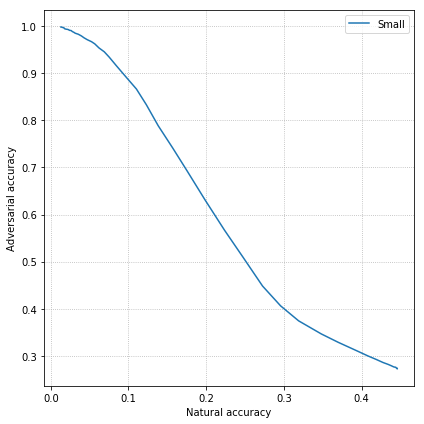

In [19]:
plt.figure()

# Set height = width
fig = plt.gcf()
width, height = fig.get_size_inches()
fig.set_size_inches(width, width)

for dataset, label in zip(["IBP_CIFAR10_SmallCNN_train_0.035_eval_0.031_elide/May06_13-56-54/weights_350_0.265__linf-norm-bounded-0.031372549__Inf__0.0",
                           #"IBP_CIFAR10_LargeCNN_2_train_0.035_eval_0.031_elide/May10_21-26-24/weights_400_0.271__linf-norm-bounded-0.031372549__Inf__0.0"
                          ],
                          ["Small", #"Large2"
                          ]):

    filename = "verification_results/validation/" + dataset + "/summary.csv"
    nat_accuracies, adv_accuracies = get_accuracies_valid(filename, dataset="cifar")
    plt.plot(nat_accuracies, adv_accuracies, label=label)
    plt.xlabel("Natural accuracy")
    plt.ylabel("Adversarial accuracy")

    plt.grid(True, "both", linestyle="dotted")

    max_min = 0
    nat_acc = -1
    adv_acc = -1
    epsilon = 0
    for (a, b, c) in zip(nat_accuracies, adv_accuracies, range(-24, 41)):
        if min(a, b) > max_min:
            max_min = min(a, b)
            nat_acc = a
            adv_acc = b
            epsilon = c / 10

    print("Maximise nat and adv accuracy at delta = ", epsilon)
    print("Nat accuracy", nat_acc)
    print("Adv accuracy", adv_acc, "\n")
    print(nat_accuracies[0], adv_accuracies[0])

# plt.axis([0.5,1,0.97,1])
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "verification_validation_cifar_8_255.pdf"), bbox_inches="tight", pad_inches=0)

## CIFAR-10 test results

In [20]:
for dataset in ["IBP_CIFAR10_SmallCNN_train_0.009_eval_0.008_elide/May06_13-14-55/weights_350_0.434__linf-norm-bounded-0.007843137__Inf__0.0",
                "IBP_CIFAR10_SmallCNN_train_0.035_eval_0.031_elide/May06_13-56-54/weights_350_0.265__linf-norm-bounded-0.031372549__Inf__0.0"]:
    filename = "verification_results/test/" + dataset + "/summary.csv"
    print(dataset)
    print(get_accuracies_test(filename, dataset="cifar"))
    print()

IBP_CIFAR10_SmallCNN_train_0.009_eval_0.008_elide/May06_13-14-55/weights_350_0.434__linf-norm-bounded-0.007843137__Inf__0.0
{'ProvablyRobustByClass': 4505, 'Vulnerable': 5495}
(0.5912, 0.4505)

IBP_CIFAR10_SmallCNN_train_0.035_eval_0.031_elide/May06_13-56-54/weights_350_0.265__linf-norm-bounded-0.031372549__Inf__0.0
{'ProvablyRobustByClass': 2698, 'Vulnerable': 7302}
(0.4539, 0.2698)



## CIFAR use human experts

In [21]:
for dataset in ["IBP_CIFAR10_SmallCNN_train_0.009_eval_0.008_elide/May06_13-14-55/weights_350_0.434__linf-norm-bounded-0.007843137__Inf__0.0",
                "IBP_CIFAR10_SmallCNN_train_0.035_eval_0.031_elide/May06_13-56-54/weights_350_0.265__linf-norm-bounded-0.031372549__Inf__0.0"]:
    filename = "verification_results/validation/" + dataset + "/summary.csv"
    dt = get_dt(filename, cifar10_valid_labels)
    nat_results = [(dt["NaturalInputMinDistance"].values >= x / 10).sum()
                   for x in range(-24, 40)] # Exclude 4.0 distance
    nat_accuracies, adv_accuracies = get_accuracies_valid(filename, dataset="cifar")

    nat_results = [x for x in nat_results if x >= 4200]
    index = len(nat_results)
    print(index, (index - 24) / 10, nat_results[-1], nat_accuracies[index], adv_accuracies[index])

26 0.2 4268 0.545 0.5254
24 0.0 4346 0.4084 0.2998


## Withold 5%

In [22]:
for dataset, index in zip(["IBP_CIFAR10_SmallCNN_train_0.009_eval_0.008_elide/May06_13-14-55/weights_350_0.434__linf-norm-bounded-0.007843137__Inf__0.0",
                           "IBP_CIFAR10_SmallCNN_train_0.035_eval_0.031_elide/May06_13-56-54/weights_350_0.265__linf-norm-bounded-0.031372549__Inf__0.0"],
                          [22,20]):
    threshold = (index - 24) / 10
    filename = "verification_results/test_min_dist_" + str(threshold) + "/" + dataset + "/summary.csv"
    print(get_accuracies_test_human_experts(filename, threshold, dataset="cifar"))

{'ProvablyRobustByClass': 4505, 'InfeasibleDistance': 140, 'Vulnerable': 5355}
(0.6317, 0.4645, 0.0556)
{'ProvablyRobustByClass': 2698, 'InfeasibleDistance': 51, 'Vulnerable': 7251}
(0.4878, 0.2749, 0.0435)


## Withold 10%

In [23]:
for dataset, index in zip(["IBP_CIFAR10_SmallCNN_train_0.009_eval_0.008_elide/May06_13-14-55/weights_350_0.434__linf-norm-bounded-0.007843137__Inf__0.0",
                           "IBP_CIFAR10_SmallCNN_train_0.035_eval_0.031_elide/May06_13-56-54/weights_350_0.265__linf-norm-bounded-0.031372549__Inf__0.0"],
                          [24,22]):
    threshold = (index - 24) / 10
    filename = "verification_results/test_min_dist_" + str(threshold) + "/" + dataset + "/summary.csv"
    print(get_accuracies_test_human_experts(filename, threshold, dataset="cifar"))

{'ProvablyRobustByClass': 4505, 'InfeasibleDistance': 310, 'Vulnerable': 5185}
(0.6712, 0.4815, 0.1122)
{'ProvablyRobustByClass': 2698, 'InfeasibleDistance': 138, 'Vulnerable': 7164}
(0.5237, 0.2836, 0.0914)


## Withold 20%

In [24]:
for dataset, index in zip(["IBP_CIFAR10_SmallCNN_train_0.009_eval_0.008_elide/May06_13-14-55/weights_350_0.434__linf-norm-bounded-0.007843137__Inf__0.0",
                           "IBP_CIFAR10_SmallCNN_train_0.035_eval_0.031_elide/May06_13-56-54/weights_350_0.265__linf-norm-bounded-0.031372549__Inf__0.0"],
                          [26,24]):
    threshold = (index - 24) / 10
    filename = "verification_results/test_min_dist_" + str(threshold) + "/" + dataset + "/summary.csv"
    print(get_accuracies_test_human_experts(filename, threshold, dataset="cifar"))

{'ProvablyRobustByClass': 4505, 'InfeasibleDistance': 621, 'Vulnerable': 4874}
(0.7241, 0.5126, 0.1916)
{'ProvablyRobustByClass': 2698, 'InfeasibleDistance': 185, 'Vulnerable': 7117}
(0.5833, 0.2883, 0.1745)


## Fashion MNIST

Maximise nat and adv accuracy at delta =  0.5
Nat accuracy 0.7752
Adv accuracy 0.7786 

0.8248 0.7274
Only 637 samples verified so far
Maximise nat and adv accuracy at delta =  0.5
Nat accuracy 0.8021978021978022
Adv accuracy 0.7943485086342229 

0.8351648351648352 0.7582417582417582


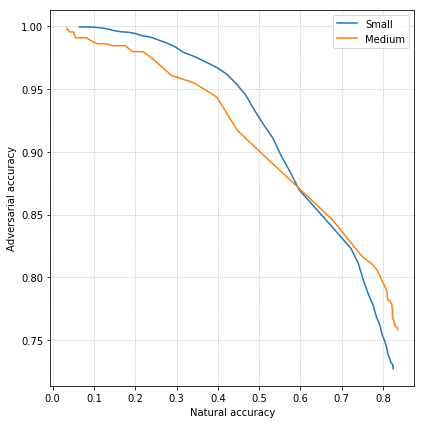

In [25]:
plt.figure()

# Set height = width
fig = plt.gcf()
width, height = fig.get_size_inches()
fig.set_size_inches(width, width)

for dataset, label in zip(["IBP_FASHION_MNIST_SmallCNN_train_0.125_eval_0.100_elide/May14_22-12-35/weights_200_0.725__linf-norm-bounded-0.1__Inf__0.0",
                           "IBP_FASHION_MNIST_MediumCNN_train_0.125_eval_0.100_elide/May14_23-38-31/weights_200_0.733__linf-norm-bounded-0.1__Inf__0.0"],
                          ["Small", "Medium"]):

    filename = "verification_results/validation/" + dataset + "/summary.csv"
    nat_accuracies, adv_accuracies = get_accuracies_valid(filename, dataset="fashion_mnist")
    plt.plot(nat_accuracies, adv_accuracies, label=label)
    plt.xlabel("Natural accuracy")
    plt.ylabel("Adversarial accuracy")

    plt.grid(True, "both", linestyle="dotted")

    max_min = 0
    nat_acc = -1
    adv_acc = -1
    epsilon = 0
    for (a, b, c) in zip(nat_accuracies, adv_accuracies, range(-24, 41)):
        if min(a, b) > max_min:
            max_min = min(a, b)
            nat_acc = a
            adv_acc = b
            epsilon = c / 10

    print("Maximise nat and adv accuracy at delta = ", epsilon)
    print("Nat accuracy", nat_acc)
    print("Adv accuracy", adv_acc, "\n")
    print(nat_accuracies[0], adv_accuracies[0])

# plt.axis([0.5,1,0.97,1])
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "verification_validation_fashion_mnist_01.pdf"), bbox_inches="tight", pad_inches=0)